In [1]:
# Qiskit imports
from qiskit import (
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
)
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise import QuantumError
from qiskit.quantum_info import Pauli

# Step 1. Build quantum circuit for the n-qubit repetition code

In [2]:
def init_circuit(num_data):
    """ Initializes quantum circuit """

    assert(num_data % 2 == 1), "Number of data qubits MUST be odd"

    num_ancilla = num_data - 1

    # Create a single quantum register with all qubits
    qreg_data = QuantumRegister(num_data, name='q')
    qreg_ancilla = QuantumRegister(num_ancilla, name='ancilla')
    creg_data = ClassicalRegister(num_data, name='data')
    creg_ancilla = ClassicalRegister(num_ancilla, name='syndrome')

    # Initialize circuit with ancilla information
    circuit = QuantumCircuit(qreg_data, qreg_ancilla, creg_data, creg_ancilla)
    circuit._ancillas = list(range(num_data, circuit.num_qubits))  # Mark last n_ancilla qubits as ancillas
    return circuit



def encode_circuit(circuit: QuantumCircuit):
    """ Encodes physical 1-qubit state into logical n-qubit repetition state """

    for i in range(circuit.num_qubits - circuit.num_ancillas - 1):
        circuit.cx(0, 1 + i)
    
    circuit.barrier(label="Encoding")
    return circuit



def noisy_channel(circuit: QuantumCircuit):
    """
    Instead of using Kraus operators which are not supported by qiskit stabilizer simulator, 
    we implement noisy identity qubit gates to simulate noisy channel 
    """

    num_data = circuit.num_qubits - circuit.num_ancillas
    for qubit in range(num_data):
        circuit.id(qubit)
    circuit.barrier(label="Noisy channel")
    return circuit



def syndrome_measurement_circuit(circuit: QuantumCircuit):
    """ Measures all Z_{i} Z_{i+1} stabilizers"""
    num_data = circuit.num_qubits - circuit.num_ancillas
    for i in range(circuit.num_ancillas):
        circuit.cx(i, num_data + i)
        circuit.cx(i + 1, num_data + i)
        circuit.measure(circuit.qregs[1][i], circuit.cregs[1][i])
        circuit.reset(circuit.qregs[1][i])  # ancillas must be reset so that final stabilizer-state accounts for logical errors only
    circuit.barrier(label="Syndrome")
    return circuit


def final_measurement(circuit: QuantumCircuit):
    m_list = [i for i in range(circuit.num_qubits - circuit.num_ancillas)]
    circuit.measure(m_list, m_list[::-1])

### Building decoder

Decoder is built by implementing majority vote system. Given the string of parities between i and (i+1) qubit we can count how many qubits are of the same parity as the first one, and how many qubits are of the different parity. 

We then compare these numbers and decide which set of qubits are needed to be flipped.

In [3]:
def syndrome_correction(circuit: QuantumCircuit, measured_syndrome):
    measured_syndrome = measured_syndrome[::-1]  # https://quantumcomputing.stackexchange.com/questions/8893/why-is-the-order-reversed-on-measurement
    correction_string = '0'
    for i in range(len(measured_syndrome)):
        correction_string += str(int(measured_syndrome[i]) ^ int(correction_string[-1]))
    
    bit_occurences = {'0': [], '1': []} 
    for i,x in  enumerate(correction_string):
        bit_occurences[x].append(i)
    
    num0 = correction_string.count('0')
    num1 = correction_string.count('1')
    if (num0 < num1) and (num0 > 0):
        circuit.x(bit_occurences['0'])
    elif (num1 < num0) and (num1 > 0):
        circuit.x(bit_occurences['1'])
    circuit.barrier(label="Correction")
    return circuit

# Step 2. Run simulation and compare stabilizer states at the output of noiseless and noisy circuits

## Step 2.1. Construct and simulate ideal circuit (no noise, no decoding)

The noiseless circuit is simulated to calculate ideal evolution of the initial state, which serves as a reference state for noisy simulations.

In [4]:
num_data=5
qc_ideal = init_circuit(num_data)
encode_circuit(qc_ideal)
syndrome_measurement_circuit(qc_ideal)
qc_ideal.save_stabilizer(label='stabilizer_ideal')
# qc_ideal.draw(output="mpl")

In [5]:
simulator_ideal = AerSimulator(method="stabilizer")
result = simulator_ideal.run(qc_ideal, shots=1).result()
stabilizer_ideal = result.data(0)['stabilizer_ideal']

## Step 2.2. Construct and simulate noisy circuit

Circuit with noise consists of two parts:
1. circuit that measures syndromes
2. circuit that corrects a given measurements with decoder 

To accurately simulate the second part it should be initialized in a stabilizer state at the output of the first part.

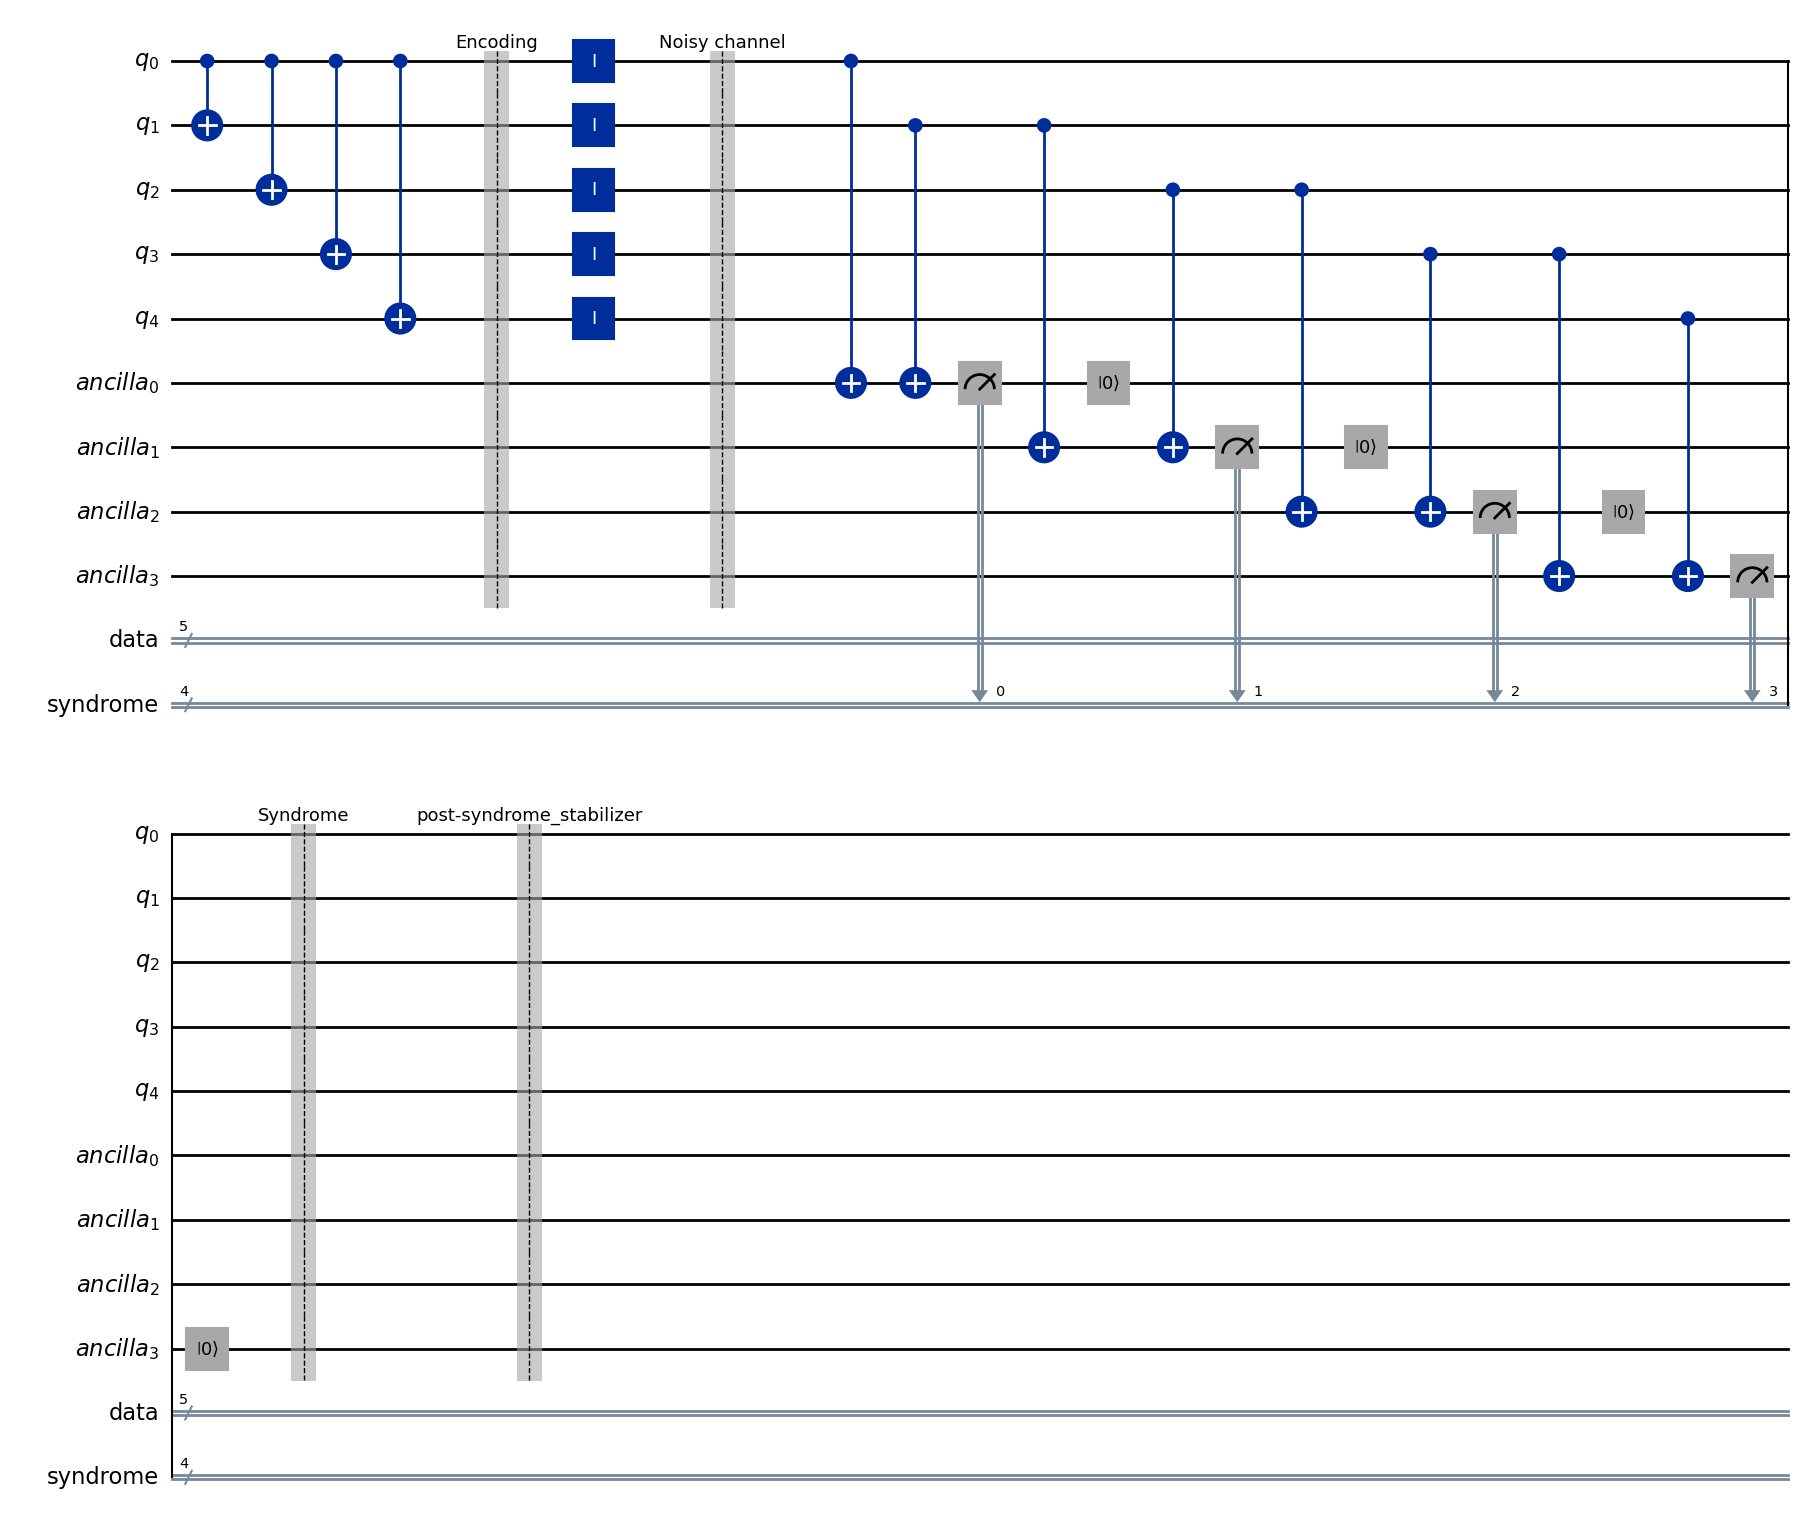

In [6]:
qc_noisy_syndrome = init_circuit(num_data)
encode_circuit(qc_noisy_syndrome)
noisy_channel(qc_noisy_syndrome)
syndrome_measurement_circuit(qc_noisy_syndrome)
qc_noisy_syndrome.save_stabilizer('post-syndrome_stabilizer')
qc_noisy_syndrome.draw("mpl")

To run noisy simulations the noise model must be built first. 

In a given example is just an 'X'-error applied to each data qubit of the circuit at a certain moment.

In [7]:
def create_single_qubit_pauli_error(p):
    paulis = [Pauli('I'), Pauli('X')]
    probs = [1-p, p]
    return QuantumError(zip(paulis, probs))

prob = 0.25
noise_model = NoiseModel()
error = create_single_qubit_pauli_error(prob)
noise_model.add_all_qubit_quantum_error(error, ["id"])

In [8]:
simulator_noisy = AerSimulator(method='stabilizer', noise_model=noise_model)
result_noisy_syndrome = simulator_noisy.run(qc_noisy_syndrome, shots=1).result()
measured_string = result_noisy_syndrome.get_counts()
measured_string = list(measured_string.keys())[0][:-num_data - 1]  # getting rid of data qubits register and a space between two registers
post_syndrome_stabilizer = result_noisy_syndrome.data(0)['post-syndrome_stabilizer']

print(measured_string[::-1])
print(post_syndrome_stabilizer) 

1110
StabilizerState(['-IIIIIIIIZ', '-IIIIIIIZZ', '+IIIIIIZIZ', '-IIIIIZIIZ', '-IIIIZIIIZ', '-IIIZIIIZZ', '-IIZIIIZZI', '-IZIIIZZII', '+ZIIIZZIII'])


Now we are ready to build and simulate the part of the circuit with error correction.

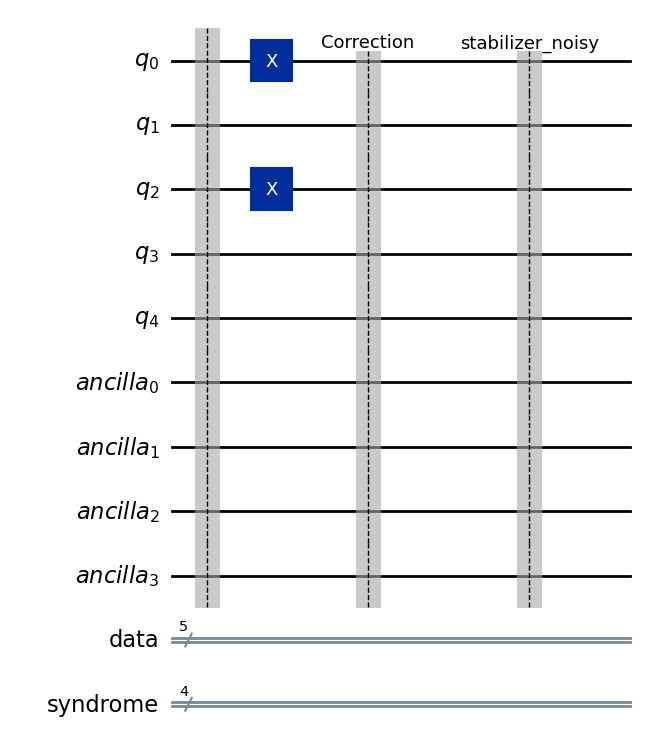

In [9]:
qc_noisy_correction = init_circuit(num_data)
qc_noisy_correction.set_stabilizer(post_syndrome_stabilizer)
syndrome_correction(qc_noisy_correction, measured_string)
qc_noisy_correction.save_stabilizer('stabilizer_noisy')
qc_noisy_correction.draw(output="mpl")

In [10]:
result_noisy_correction = simulator_noisy.run(qc_noisy_correction, shots=1000).result()
stabilizer_noisy = result_noisy_correction.data(0)['stabilizer_noisy']

compare ideal and noisy results

In [11]:
print(stabilizer_ideal)
print(stabilizer_noisy)
print(stabilizer_ideal==stabilizer_noisy)

StabilizerState(['+IIIIIIIIZ', '+IIIIIIIZZ', '+IIIIIIZIZ', '+IIIIIZIIZ', '+IIIIZIIIZ', '+IIIZIIIZZ', '+IIZIIIZZI', '+IZIIIZZII', '+ZIIIZZIII'])
StabilizerState(['+IIIIIIIIZ', '+IIIIIIIZZ', '+IIIIIIZIZ', '+IIIIIZIIZ', '+IIIIZIIIZ', '+IIIZIIIZZ', '+IIZIIIZZI', '+IZIIIZZII', '+ZIIIZZIII'])
True


# Step 3. Generalize simulation procedure for $p_L(p)$ plot

## 3.1. Preprocessing

In [12]:
def construct_preprocessed_circuits(num_data):
    qc_ideal = init_circuit(num_data)
    encode_circuit(qc_ideal)
    syndrome_measurement_circuit(qc_ideal)
    qc_ideal.save_stabilizer(label='stabilizer_ideal')


    simulator_ideal = AerSimulator(method="stabilizer")
    result = simulator_ideal.run(qc_ideal, shots=1).result()
    stabilizer_ideal = result.data(0)['stabilizer_ideal']

    qc_noisy_syndrome = init_circuit(num_data)
    encode_circuit(qc_noisy_syndrome)
    noisy_channel(qc_noisy_syndrome)
    syndrome_measurement_circuit(qc_noisy_syndrome)
    qc_noisy_syndrome.save_stabilizer('post-syndrome_stabilizer')

    return stabilizer_ideal, qc_noisy_syndrome

## 3.2. Run simulation to calculate $p_L(p)$

In [13]:
import tqdm

def simulate_pl(num_data, prob, num_shots):

    stabilizer_ideal, qc_noisy_syndrome = construct_preprocessed_circuits(num_data)

    noise_model = NoiseModel()
    error = create_single_qubit_pauli_error(prob)
    noise_model.add_all_qubit_quantum_error(error, ["id"])
    simulator_noisy = AerSimulator(method='stabilizer', noise_model=noise_model)

    num_sucess = 0
    for _ in tqdm.tqdm(range(num_shots)):

        res = simulator_noisy.run(qc_noisy_syndrome, shots=1).result()
        res_measurements = list(res.get_counts().keys())[0][:qc_noisy_syndrome.num_ancillas]
        res_stabilizer = res.data(0)['post-syndrome_stabilizer']


        qc_noisy_correction = init_circuit(num_data)
        qc_noisy_correction.set_stabilizer(res_stabilizer)
        syndrome_correction(qc_noisy_correction, res_measurements)
        qc_noisy_correction.save_stabilizer('stabilizer_noisy')
        final_measurement(qc_noisy_correction)

        res = simulator_noisy.run(qc_noisy_correction, shots=1).result()
        res_stabilizer = res.data(0)['stabilizer_noisy']


        if stabilizer_ideal==res_stabilizer:
            num_sucess += 1
    return 1 - num_sucess / num_shots

In [14]:
from numpy import linspace

num_data = 101
p_values = linspace(0.0, 0.5, 10)
num_shots = 256

In [15]:
p_logical_simulated = [simulate_pl(num_data, probability, num_shots) for probability in p_values]

100%|██████████| 256/256 [00:47<00:00,  5.42it/s]


## 3.3. Plot results

In [16]:
import math
def calc_pL(p, n):
    """ Calculates exact probability of logical error """
    result = 0
    for k in range((n-1) // 2 + 1):
        result += math.comb(n, k) * p**(n-k) * (1-p)**k
    return result

p_logical_analytical = [calc_pL(probability, num_data) for probability in p_values]

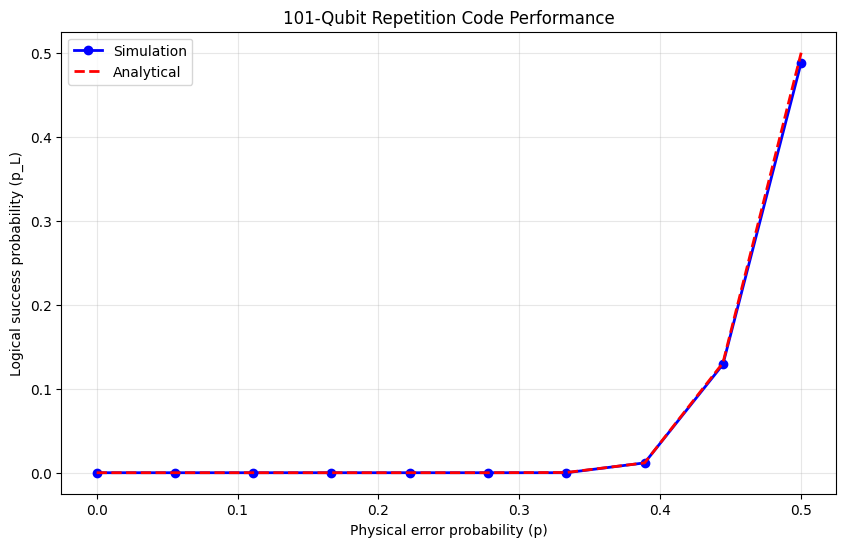

In [18]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(p_values, p_logical_simulated, 'bo-', linewidth=2, markersize=6, label='Simulation')
plt.plot(p_values, p_logical_analytical, 'r--', linewidth=2, markersize=6, label='Analytical')
plt.xlabel('Physical error probability (p)')
plt.ylabel('Logical success probability (p_L)')
plt.title(f'{num_data}-Qubit Repetition Code Performance')
plt.grid(True, alpha=0.3)

plt.legend()
plt.show()